30. Reading the POS Tagging Result

In [11]:
import zipfile
import os
from collections import defaultdict
import matplotlib.pyplot as plt

def extract_zip(zip_path, extract_to=None):
    """Extract a zip file to a specified directory or to the current directory."""
    if extract_to is None:
        extract_to = os.path.dirname(zip_path) or '.'
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return extract_to

def read_conll_file(file_path):
    sentences = []
    current_sentence = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:  # Sentence boundary
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
                continue
                
            # Split the line (assuming tab-separated)
            parts = line.split('\t')
            if len(parts) >= 4:  # At least word, lemma, POS
                token = {
                    'text': parts[1],  # Surface form
                    'lemma': parts[2],  # Lemma
                    'pos': parts[3]     # POS tag
                }
                current_sentence.append(token)
    
    if current_sentence:  # Add the last sentence if file doesn't end with newline
        sentences.append(current_sentence)
        
    return sentences

def inspect_sentences(sentences, num_sentences=2, num_tokens=5):
    """Print sample sentences for inspection."""
    for i, sentence in enumerate(sentences[:num_sentences]):
        print(f"\nSentence {i+1}:")
        for j, token in enumerate(sentence[:num_tokens]):
            print(f"  Token {j+1}: {token}")
        if len(sentence) > num_tokens:
            print(f"  ... and {len(sentence)-num_tokens} more tokens")

def extract_verbs(sentences):
    verbs = []
    for sentence in sentences:
        for token in sentence:
            if token['pos'].startswith('VB'):  # VB, VBD, VBG, VBN, VBP, VBZ
                verbs.append(token['text'])
    return verbs

def check_file_format(file_path, num_lines=10):
    """Print the first few lines of a file to inspect its format."""
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return False
    
    print(f"First {num_lines} lines of {file_path}:")
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= num_lines:
                break
            print(f"{i+1}: {line.strip()}")
    return True

# 1. Extract the zip file
zip_path = '/home/jace/nlp100/4 POS tagging/alice.zip'
if not os.path.exists(zip_path):
    print(f"Error: Zip file not found at {zip_path}")
    
extracted_dir = extract_zip(zip_path)
conll_path = os.path.join(extracted_dir, 'alice.txt.conll')
    
# 2. Verify the file exists and check its format
# 3. Read the CONLL file
try:
    sentences = read_conll_file(conll_path)
    if not sentences:
        print("No sentences were parsed from the CONLL file")
        
except Exception as e:
    print(f"Error reading CONLL file: {e}")
    
 # 4. Inspect the first few sentences
inspect_sentences(sentences)
# 5. Extract verbs
verbs = extract_verbs(sentences)
print(f"\nFound {len(verbs)} verbs. First 10: {verbs[:10]}")


Sentence 1:
  Token 1: {'text': 'ALICE', 'lemma': 'ALICE', 'pos': 'NNP'}
  Token 2: {'text': "'S", 'lemma': "'s", 'pos': 'POS'}
  Token 3: {'text': 'ADVENTURES', 'lemma': 'ADVENTURES', 'pos': 'NNP'}
  Token 4: {'text': 'IN', 'lemma': 'in', 'pos': 'IN'}
  Token 5: {'text': 'WONDERLAND', 'lemma': 'WONDERLAND', 'pos': 'NNP'}

Sentence 2:
  Token 1: {'text': 'Lewis', 'lemma': 'Lewis', 'pos': 'NNP'}
  Token 2: {'text': 'Carroll', 'lemma': 'Carroll', 'pos': 'NNP'}

Found 5722 verbs. First 10: ['was', 'beginning', 'get', 'sitting', 'having', 'do', 'had', 'peeped', 'was', 'reading']


31. Extract Surface Forms of All Verbs


In [12]:
def extract_verbs(sentences):
    verbs = []
    for sentence in sentences:
        for token in sentence:
            if token['pos'].startswith('VB'):  # VB, VBD, VBG, VBN, VBP, VBZ
                verbs.append(token['text'])
    return verbs
verbs = extract_verbs(sentences)
print("Sample verbs:", verbs[:10])


Sample verbs: ['was', 'beginning', 'get', 'sitting', 'having', 'do', 'had', 'peeped', 'was', 'reading']


32. Extract Lemmas of All Verbs


In [13]:
def extract_verb_lemmas(sentences):
    verb_lemmas = []
    for sentence in sentences:
        for token in sentence:
            if token['pos'].startswith('VB'):
                verb_lemmas.append(token['lemma'])
    return verb_lemmas
verb_lemmas = extract_verb_lemmas(sentences)
print("Sample verb lemmas:", verb_lemmas[:10])


Sample verb lemmas: ['be', 'begin', 'get', 'sit', 'have', 'do', 'have', 'peep', 'be', 'read']


33. Extract "A of B" Noun Phrases


In [14]:
def extract_a_of_b(sentences):
    a_of_b_phrases = []
    for sentence in sentences:
        for i in range(len(sentence) - 2):
            # Check for pattern: noun + 'of' + noun
            if (sentence[i]['pos'].startswith('NN') and 
                sentence[i+1]['text'].lower() == 'of' and 
                sentence[i+2]['pos'].startswith('NN')):
                phrase = f"{sentence[i]['text']} {sentence[i+1]['text']} {sentence[i+2]['text']}"
                a_of_b_phrases.append(phrase)
    return a_of_b_phrases
a_of_b = extract_a_of_b(sentences)
print("Sample A of B phrases:", a_of_b[:10])


Sample A of B phrases: ['OUT OF ITS', 'plenty of time', 'saucer of milk', 'sort of way', 'heap of sticks', 'row of lamps', 'book of rules', 'flavour of cherry-tart', 'game of croquet', 'Pool of Tears']


34. Extract Longest Consecutive Noun Sequence

In [15]:
def extract_longest_noun_sequence(sentences):
    longest_sequence = []
    for sentence in sentences:
        current_sequence = []
        for token in sentence:
            if token['pos'].startswith('NN'):  # Noun
                current_sequence.append(token['text'])
            else:
                if len(current_sequence) > len(longest_sequence):
                    longest_sequence = current_sequence.copy()
                current_sequence = []
        # Check at end of sentence
        if len(current_sequence) > len(longest_sequence):
            longest_sequence = current_sequence.copy()
    return ' '.join(longest_sequence)
longest_noun_seq = extract_longest_noun_sequence(sentences)
print("Longest noun sequence:", longest_noun_seq)


Longest noun sequence: Ou est ma chatte


35. Word Frequency List


In [16]:
from collections import defaultdict

def word_frequencies(sentences):
    freq = defaultdict(int)
    for sentence in sentences:
        for token in sentence:
            word = token['text'].lower()
            freq[word] += 1
    return sorted(freq.items(), key=lambda x: x[1], reverse=True)
freq_list = word_frequencies(sentences)
print("Top 10 frequent words:", freq_list[:10])


Top 10 frequent words: [(',', 2418), ('the', 1639), ("'", 1130), ('`', 1081), ('.', 986), ('and', 866), ('to', 725), ('a', 631), ('it', 595), ('she', 553)]


36. Top-Ten Frequent Words Visualization


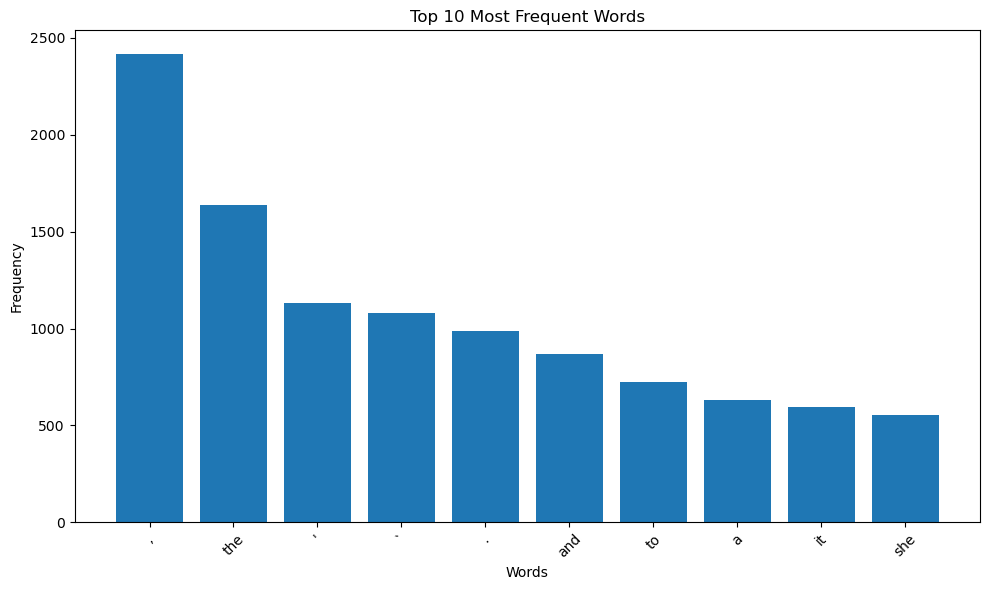

In [17]:
import matplotlib.pyplot as plt

def plot_top_ten_words(freq_list):
    top_ten = freq_list[:10]
    words = [item[0] for item in top_ten]
    counts = [item[1] for item in top_ten]
    
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Most Frequent Words')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_top_ten_words(freq_list)


37. Top-Ten Words Co-occurring with "Alice"


Top 10 co-occurring words: [(',', 344), ('said', 141), ("'", 134), ('.', 95), ('to', 94), ('`', 84), ('and', 76), ('the', 69), ('a', 50), ('thought', 43)]


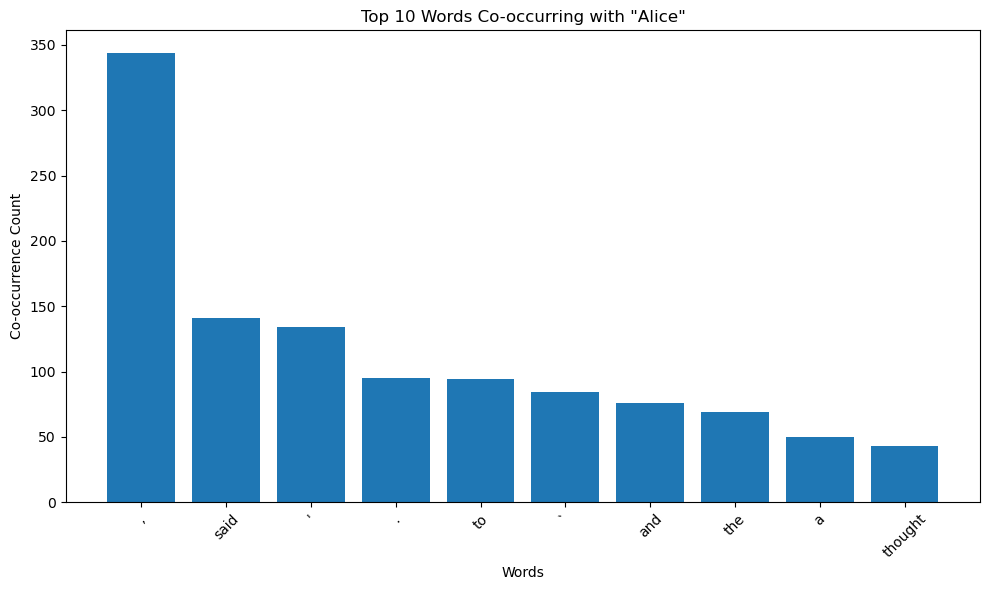

In [18]:
def words_cooccurring_with_alice(sentences):
    cooccur = defaultdict(int)
    alice_window = 5  # Words before and after Alice to consider
    
    for sentence in sentences:
        for i, token in enumerate(sentence):
            if token['text'].lower() == 'alice':
                # Get surrounding words
                start = max(0, i - alice_window)
                end = min(len(sentence), i + alice_window + 1)
                for j in range(start, end):
                    if j != i:  # Don't count Alice itself
                        word = sentence[j]['text'].lower()
                        if not sentence[j]['pos'].startswith('NNP'):  # Skip proper nouns
                            cooccur[word] += 1
    return sorted(cooccur.items(), key=lambda x: x[1], reverse=True)

def plot_top_cooccurring_words(cooccur_list):
    top_ten = cooccur_list[:10]
    words = [item[0] for item in top_ten]
    counts = [item[1] for item in top_ten]
    
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Co-occurrence Count')
    plt.title('Top 10 Words Co-occurring with "Alice"')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
cooccur_list = words_cooccurring_with_alice(sentences)
print("Top 10 co-occurring words:", cooccur_list[:10])
plot_top_cooccurring_words(cooccur_list)


38. Word Frequency Histogram


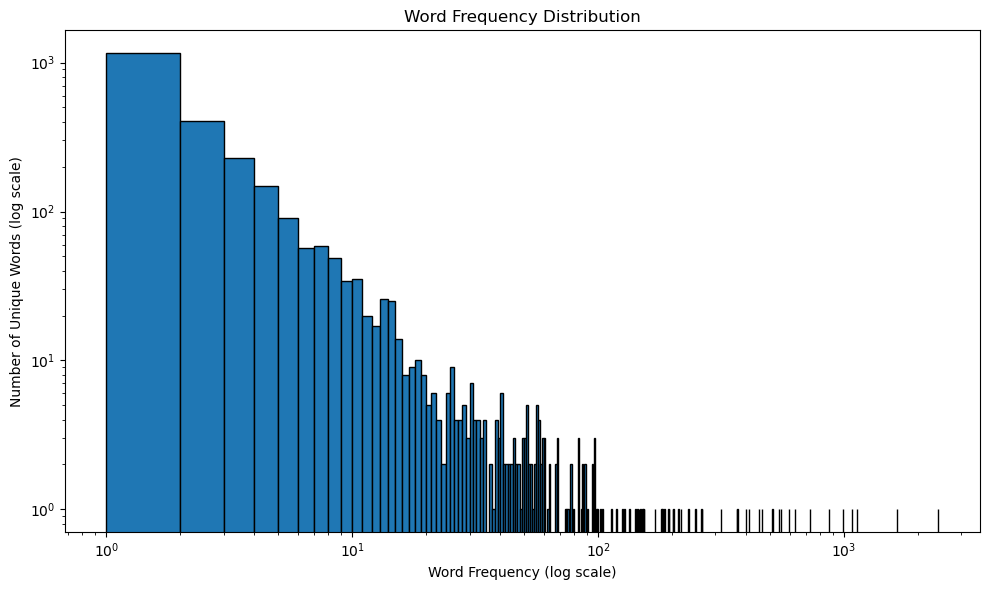

In [19]:
def plot_word_frequency_histogram(freq_list):
    frequencies = [freq for word, freq in freq_list]
    max_freq = max(frequencies)
    
    plt.figure(figsize=(10, 6))
    plt.hist(frequencies, bins=range(1, max_freq + 1), edgecolor='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Word Frequency (log scale)')
    plt.ylabel('Number of Unique Words (log scale)')
    plt.title('Word Frequency Distribution')
    plt.tight_layout()
    plt.show()
plot_word_frequency_histogram(freq_list)

39. Zipf's Law Plot


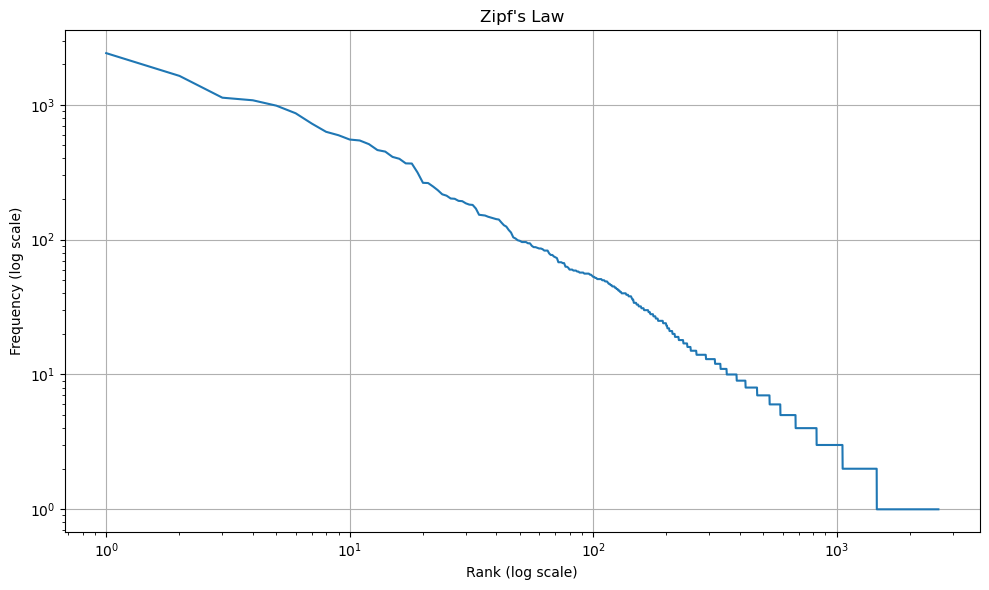

In [20]:
def plot_zipfs_law(freq_list):
    frequencies = [freq for word, freq in freq_list]
    ranks = range(1, len(frequencies) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies)
    plt.xlabel('Rank (log scale)')
    plt.ylabel('Frequency (log scale)')
    plt.title("Zipf's Law")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_zipfs_law(freq_list)
